In [74]:
import pytesseract as ocr
import cv2 as cv
import sys
import glob
import numpy as np
import yaml

from dataclasses import dataclass
import dataclasses
from typing import List



def imshow(image):
    ww = 1024
    h, w = image.shape[:2]

    if w > ww:
        hh = int(ww / w * h)
        image = cv.resize(image, dsize=[ww, hh])

    _, ret = cv.imencode('.jpg', image) 

    from IPython.display import display, Image
    display(Image(data=ret))
cv.imshow = imshow

test_video.mp4
0


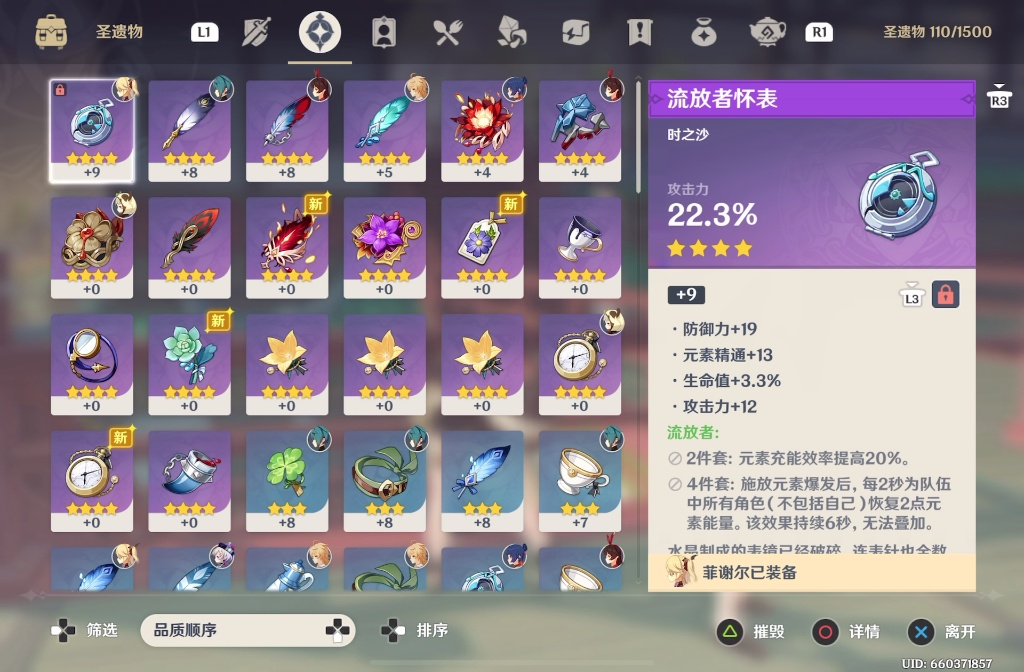

1


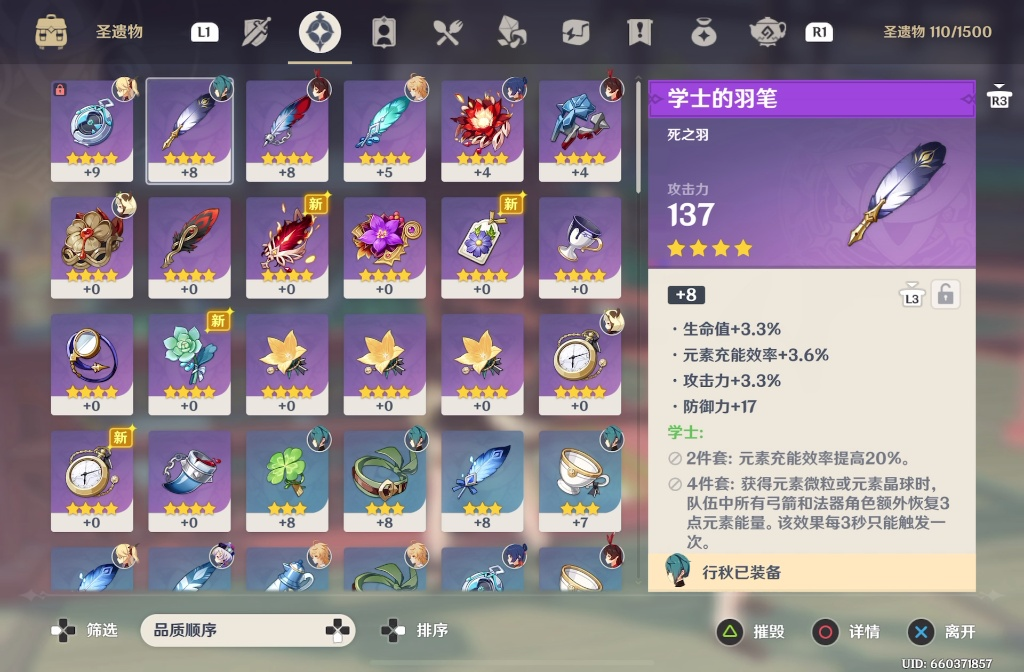

2


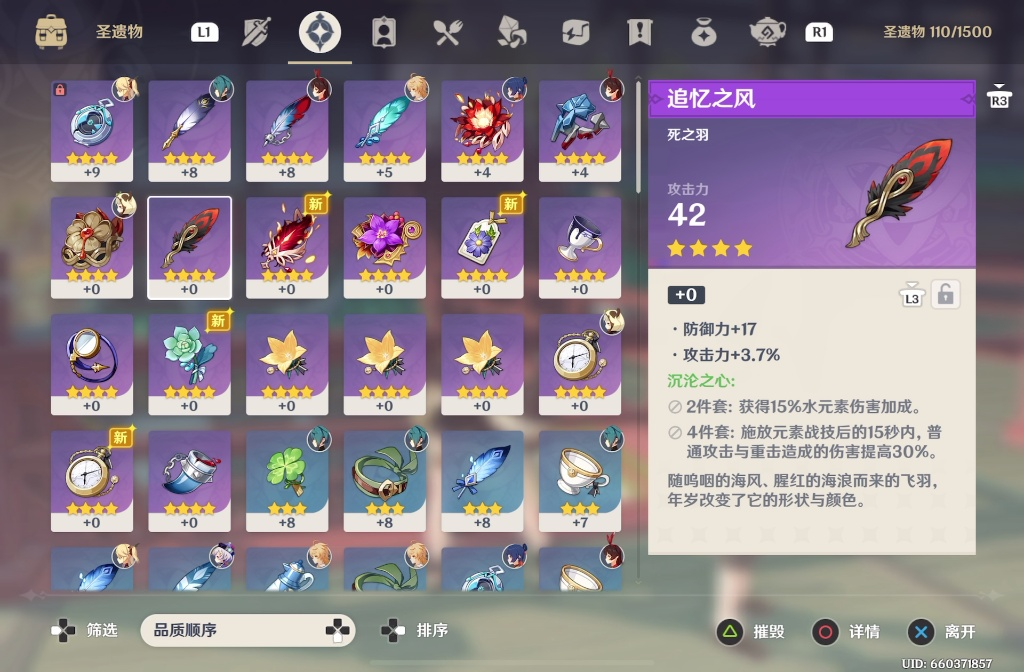

In [75]:
class FrameReader:
  capture: cv.VideoCapture

  def __init__(self, path, time=None, interval=None):
    self.capture = capture = cv.VideoCapture(path)
    self.n_frame = capture.get(cv.CAP_PROP_FRAME_COUNT)
    self.sample_rate = capture.get(cv.CAP_PROP_FPS)
    self.duration = self.n_frame / self.sample_rate

    self.time = 0
    self.interval = interval
    self.frame_time = None

    if time:
      self.time = time
      self.capture.set(cv.CAP_PROP_POS_MSEC, int(time * 1000))

  def next(self):
    self.frame_time = self.time
    valid, frame = self.capture.read()
    if not valid:
      return None

    if self.interval:
      self.time += self.interval
      self.capture.set(cv.CAP_PROP_POS_MSEC, int(self.time * 1000))


    return frame


filename = glob.glob("*.[mM][pP]4")
filename = list(filename)[0]
print(filename)
reader = FrameReader(filename, time=0, interval=1)

for i in range(3):
  frame = reader.next()
  print(reader.frame_time)
  cv.imshow(frame)


reading 'RPReplay_Final1674756352.mp4'
duration = 39.79s
True
(1260, 1920, 3)
(672, 1024, 3)


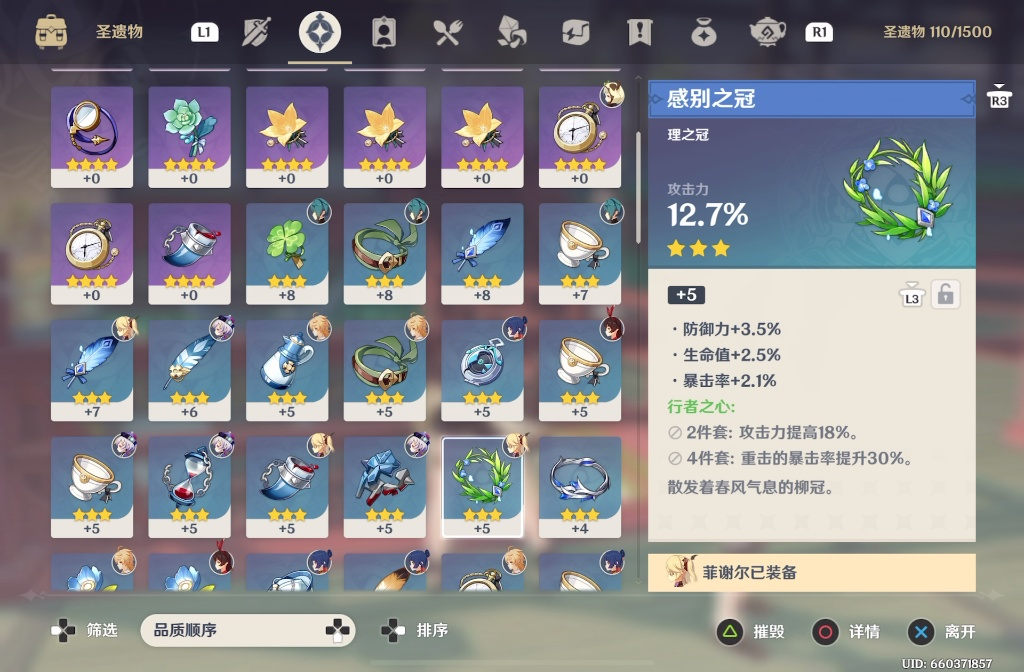

In [11]:
filename = glob.glob("*.[mM][pP]4")
filename = list(filename)[0]
print(f"reading {filename!r}")

def frames(start_seconds=0):
  cap = cv.VideoCapture(filename)

  n_frame = cap.get(cv.CAP_PROP_FRAME_COUNT)
  sample_rate = cap.get(cv.CAP_PROP_FPS)
  duration = n_frame / sample_rate

  print(f"{duration = :.2f}s")

  ms = int(start_seconds * 1000)
  cap.set(cv.CAP_PROP_POS_MSEC, ms)

  return cap

cap = frames(start_seconds=30)
ret, frame = cap.read()

print(ret)
print(frame.shape)
imshow(frame)

In [12]:
@dataclass
class Artifact:
  type: str
  name: str
  level: str

  main_stat: str
  sub_stats: Dict[str, str]

In [13]:
def load_artifact_names():
  with open("artifacts.yaml") as f:
    artifact_data = yaml.load(f, Loader=yaml.FullLoader)

  artifact_names = []
  for key, combo in artifact_data.items():
    if key == "glacier-and-snowfield":
      continue
    for name in combo['item-name'].values():
      artifact_names.append(name)

  assert(len(artifact_names) == len(set(artifact_names)))
  # # if not 
  # import collections
  # {k:v for k, v in collections.Counter(artifact_names).items() if v>1}

  artifact_names = set(artifact_names)
  return artifact_names

In [14]:
artifact_names = load_artifact_names()
artifact_types = "生之花 死之羽 时之沙 空之杯 理之冠".split()

def match_artifact_type(s):
  for artifact_type in artifact_types:
    if artifact_type in s:
      return artifact_type
  raise KeyError("artifact type does not exist")

s = '流放者怀表\n\n时之沙\n\n攻击力\n\n22.3%\n\x0c'
match_artifact_type(s)

'时之沙'

In [58]:
def match_artifact_name(s):
  for name in artifact_names:
    if name in s:
      return name
  raise KeyError(f"artifact name does not exist in {s!r}")

s = '流放者怀表\n\n时之沙\n\n攻击力\n\n22.3%\n\x0c'
match_artifact_name(s)

'流放者怀表'

In [16]:
main_stats = "生命值 攻击力	防御力 元素精通 元素充能效率 物理伤害加成 暴击率 暴击伤害 治疗加成".split()
main_stats += [element+"元素伤害加成" for element in "火水风草冰雷岩"]

import re
value_re = re.compile(r'\d+\.\d+%|\d+')

def match_main_stat(s):
  matched = False
  for stat in main_stats:
    if stat in s:
      matched = True
      break
  if not matched:
    raise KeyError(f"no matched main stat in {s!r}")

  value = value_re.search(s)
  if value is None:
    raise KeyError(f"no value found in {s!r}")

  return stat, value[0]

s = '流放者怀表\n\n时之沙\n\n攻击力\n\n22.3%\n\x0c'
ret = match_main_stat(s)
print(ret)

('攻击力', '22.3%')


In [17]:
sub_stat_re = re.compile(
    r'(生命值|攻击力|防御力|元素精通|暴击率|暴击伤害|元素充能效率)'
    r'\+(\d+\.\d+%|\d+)')


def match_sub_stat(ln):
  groups = sub_stat_re.search(ln)
  if groups is None:
    return None
  return groups[1], groups[2]

def match_sub_stats(s):
  result = {}
  for ln in s.splitlines():
    ret = match_sub_stat(ln)
    if ret is None: continue

    stat, val = ret
    result[stat] = val

  return result

s = " \n\n \n\n“ 防御力+19\n“元素精通+13\n“ 生命值+3.3%\n' 攻击力+12\n\x0c"
ret = match_sub_stats(s)
print(ret)

{'防御力': '19', '元素精通': '13', '生命值': '3.3%', '攻击力': '12'}


In [18]:
@dataclass
class ArtifactROI:
  main: list
  sub: list
  level: list
  title: list

  def scale(self, factor: float):
    props = dataclasses.asdict(self)

    def scale(l):
      return [int(i * factor) for i in l]
    props = {k: scale(v) for k, v in props.items()}
    return ArtifactROI(**props)


roi = ArtifactROI(
    main=[1214, 150, 1500, 430],
    sub=[1214, 500, 1830, 790],
    level=[1251, 530, 1324, 570],
    title=[1637, 30, 1869, 82],
)
roi.scale(0.5)

ArtifactROI(main=[607, 75, 750, 215], sub=[607, 250, 915, 395], level=[625, 265, 662, 285], title=[818, 15, 934, 41])

(472, 720, 3)


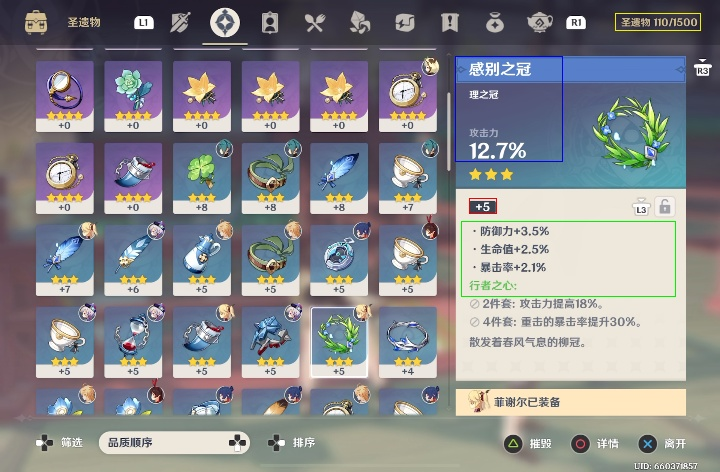

In [20]:
def draw_roi(image: np.array, roi: ArtifactROI):
  image = image.copy()

  oh, ow, _ = image.shape
  rw = 720
  ratio = rw/ow
  rh = int(oh*ratio)

  image = cv.resize(image, (rw, rh))

  def trans(roi):
    x, y, xx, yy = [int(i*ratio) for i in roi]
    return (x, y), (xx, yy)

  def color(s):
    return [int(i, base=16)*16 for i in s]
  thickness = 1
  cv.rectangle(image, *trans(roi.main), color("F00"), thickness)
  cv.rectangle(image, *trans(roi.sub), color("0F0"), thickness)
  cv.rectangle(image, *trans(roi.level), color("00F"), thickness)
  cv.rectangle(image, *trans(roi.title), color("0FF"), thickness)

  cv.imshow(image)


roi = ArtifactROI(
    main=[1214, 150, 1500, 430],
    sub=[1230, 590, 1800, 790],
    level=[1251, 530, 1324, 570],
    title=[1640, 35, 1869, 82],
)
draw_roi(frame, roi)

In [21]:
level_re = re.compile(r'\+(\d+)')

def match_level(s):
  matched = level_re.search(s)
  if not matched:
    raise KeyError("no matched level")
  return matched[1]

match_level("+12")

'12'

In [76]:
def parse_frame(image, roi):
  image = frame.copy()
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image = cv.equalizeHist(image)

  x, y, xx, yy = roi.main
  slice = image[y:yy, x:xx]
  slice = 255 - slice
  s = ocr.image_to_string(slice, lang="chi_sim+chi_tra")
  main_stat = match_main_stat(s)
  type = match_artifact_type(s)
  name = match_artifact_name(s)


  x, y, xx, yy = roi.sub
  slice = image[y:yy, x:xx]
  s = ocr.image_to_string(slice, lang="chi_sim+chi_tra")
  sub_stats = match_sub_stats(s)

  x, y, xx, yy = roi.level
  slice = 255 - image[y:yy, x:xx]
  s = ocr.image_to_string(slice)
  level = match_level(s)

  return Artifact(
      type=type,
      name=name,
      main_stat=main_stat,
      sub_stats=sub_stats,
      level=level
  )

roi = ArtifactROI(
    main=[1214, 150, 1500, 430],
    sub=[1230, 590, 1800, 790],
    level=[1251, 530, 1324, 570],
    title=[1640, 35, 1869, 82],
)
art = parse_frame(frame, roi)
dataclasses.asdict(art)

{'type': '死之羽',
 'name': '追忆之风',
 'level': '0',
 'main_stat': ('攻击力', '42'),
 'sub_stats': {'防御力': '17', '攻击力': '3.7%'}}

duration = 39.79s
(70, 72, 3)


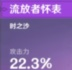

current2 25.5700
(70, 72, 3)


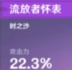

current2 25.6700
(70, 72, 3)


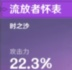

current2 25.8033
(70, 72, 3)


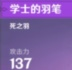

current2 25.9033
(70, 72, 3)


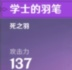

current2 26.0033
(70, 72, 3)


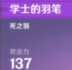

current2 26.1033
(70, 72, 3)


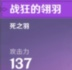

current2 26.2033
(70, 72, 3)


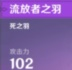

current2 26.3033
(70, 72, 3)


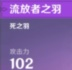

current2 26.4033
(70, 72, 3)


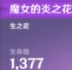

In [24]:
def interested_video_frames(start=25.5, interval=0):
  cap = frames(start_seconds=start)

  # CAP_PROP_POS_MSEC
  # CAP_PROP_POS_FRAMES
  while True:
    valid, frame = cap.read()
    if not valid:
      break
    yield frame

    if interval != 0:
      ms = cap.get(cv.CAP_PROP_POS_MSEC)
      print(f"current2 {ms/1000:.4f}")
      ms += int(interval*1000)
      cap.set(cv.CAP_PROP_POS_MSEC, int(ms))



main=[1214, 150, 1500, 430]
x, y, xx, yy = main
frame_iter = interested_video_frames(interval=0.06)
for _ in range(10):
  frame = next(frame_iter)
  frame = frame[y:yy, x:xx, :]
  frame = cv.pyrDown(frame)
  frame = cv.pyrDown(frame)
  cv.imshow(frame)

duration = 39.79s
ArtifactROI(main=[303, 37, 375, 107], sub=[307, 147, 450, 197], level=[312, 132, 331, 142], title=[410, 8, 467, 20])
False


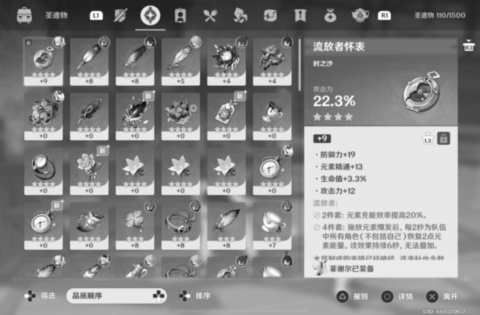

current2 25.5700
True
current2 25.6700
True
current2 25.7700
False


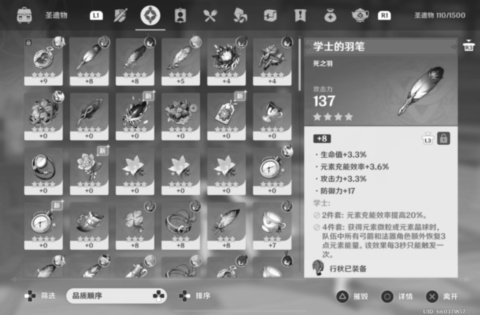

current2 25.8367
True
current2 25.9033
True
current2 25.9700
True
current2 26.0367
True
current2 26.1033
False


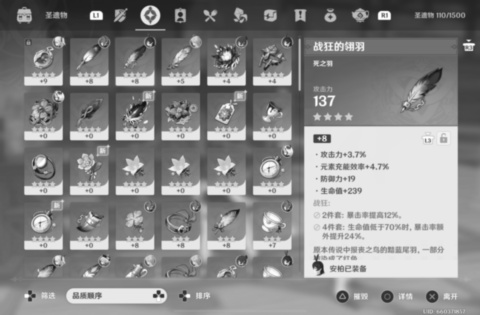

current2 26.1700
True
current2 26.2367
False


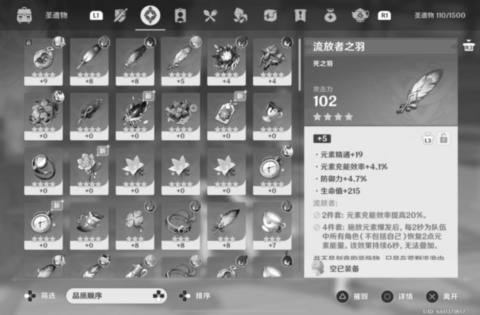

current2 26.3033
True
current2 26.3700
False


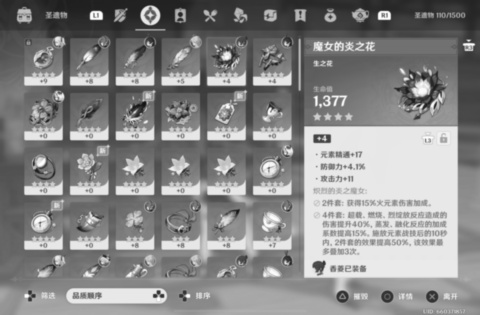

current2 26.4367
True
current2 26.5033
False


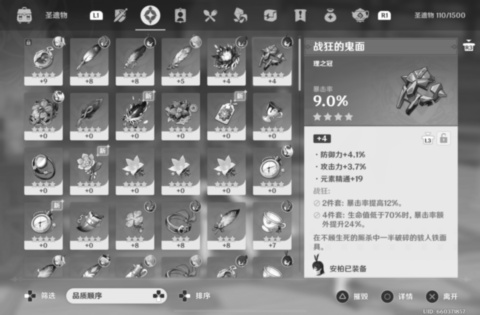

current2 26.5700
True
current2 26.6700
False


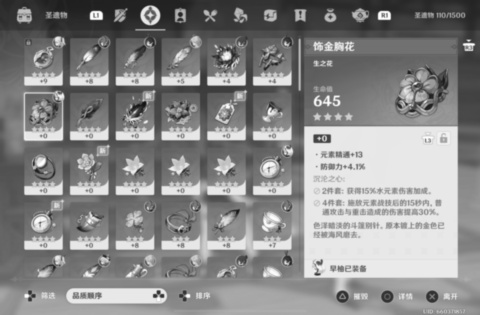

current2 26.7700
False


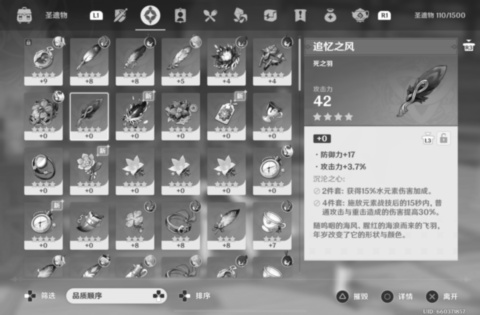

current2 26.8700
False


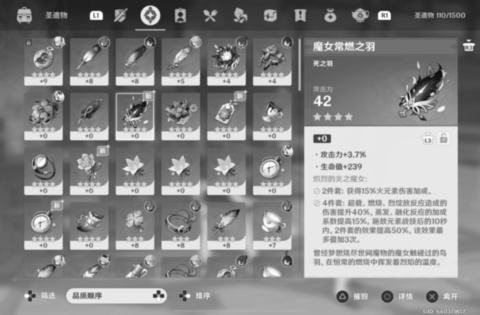

current2 26.9700
False


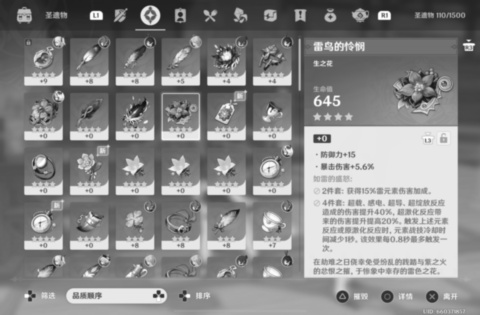

In [53]:
def pyramid_down(image, n):
  for _ in range(n):
    image = cv.pyrDown(image)
  return image

class ScreenState:
  roi: ArtifactROI
  transformed_roi: ArtifactROI
  def __init__(self, roi):
    self.roi = roi

    self.transformed_roi = None
    self.previous = None

    self.small_screen = None

  @staticmethod
  def compare_roi(current, previous):
    for k, v in current.items():
      im_prev = previous[k]
      im_curr = v

      diff = np.mean((im_prev - im_curr)**2)
      # print(f'{k} {diff=}')
      
      if diff > 0.5:
        return False
    return True

  def compare(self, screen):
    current = {}
    roi_props = dataclasses.asdict(self.transformed_roi)
    for k, v in roi_props.items():
      x, y, xx, yy = v
      current[k] = screen[y:yy, x:xx]

    result = False
    if self.previous:
      result = self.compare_roi(current, self.previous)
    self.previous = current
    return result

  def is_same(self, screen):
    small_screen = cv.cvtColor(screen, cv.COLOR_BGR2GRAY)
    small_screen = pyramid_down(small_screen, 2)
    self.small_screen = small_screen

    if not self.transformed_roi:
      w, h = small_screen.shape[:2]
      ww, hh = image.shape[:2]
      ratio = w / ww
      self.transformed_roi = self.roi.scale(ratio)
      print(self.transformed_roi)

    return self.compare(small_screen)

roi = ArtifactROI(
    main=[1214, 150, 1500, 430],
    sub=[1230, 590, 1800, 790],
    level=[1251, 530, 1324, 570],
    title=[1640, 35, 1869, 82],
)

import copy
state = ScreenState(roi)

frame_iter = interested_video_frames(interval=0.05)
for i in range(20):
  frame = next(frame_iter)

  is_same = state.is_same(frame)
  print(is_same)
  if not is_same:
    cv.imshow(state.small_screen)

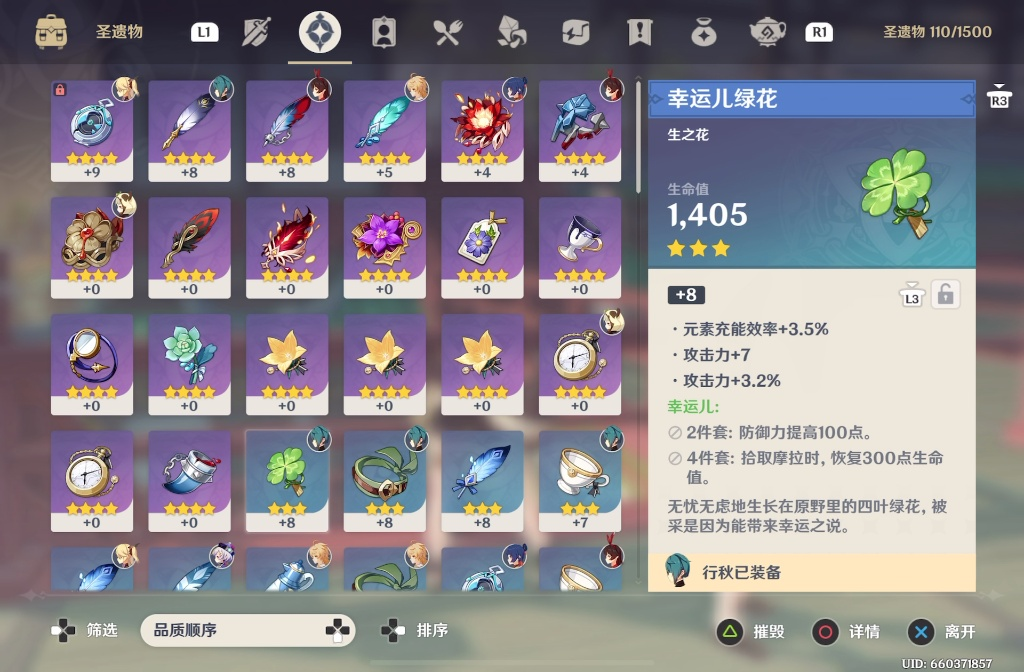

KeyError: "artifact name does not exist in '幸运儿绿人花\\n\\n生之花\\n\\n生命值\\n\\n1405\\n'"

In [72]:
reader = FrameReader(filename, time=28.2600)
frame = reader.next()

cv.imshow(frame)
parse_frame(frame, roi)

In [71]:
print(filename)
reader = FrameReader(filename, time=25.5, interval=0.04)
roi = ArtifactROI(
    main=[1214, 150, 1500, 430],
    sub=[1230, 590, 1800, 790],
    level=[1251, 530, 1324, 570],
    title=[1640, 35, 1869, 82],
)
state = ScreenState(roi)

artifacts = []
while True:
  frame = reader.next()
  if frame is None: break

  if not state.is_same(frame):
    try:
      info = parse_frame(frame, roi)
      info = dataclasses.asdict(info)
      result = dict(time=reader.frame_time, info=info)
      artifacts.append(result)
      print("pass")
    except Exception as e:
      print(f'{reader.frame_time:.4f}', e)
      artifacts.append(dict(time=reader.frame_time, error=True, message=str(e)))


len(artifacts)


RPReplay_Final1674756352.mp4
ArtifactROI(main=[303, 37, 375, 107], sub=[307, 147, 450, 197], level=[312, 132, 331, 142], title=[410, 8, 467, 20])
pass
pass
26.1400 "artifact name does not exist in '戰狂的翎羽\\n\\n死之羽\\n\\n攻击力\\n\\n137\\n'"
pass
pass
26.5400 "no matched main stat in ''"
26.6600 "artifact name does not exist in '飾金胸花\\n\\n生之花\\n\\n生命值\\n\\n645\\n'"
pass
pass
27.0200 "artifact name does not exist in '雷鸟的怜悦\\n\\n生之花\\n\\n生命值\\n\\n045\\n'"
pass
27.2200 "no matched main stat in ''"
27.3800 "no matched main stat in ''"
pass
pass
pass
pass
pass
pass
28.1400 "no matched main stat in ''"
28.2600 "artifact name does not exist in '幸运儿绿人花\\n\\n生之花\\n\\n生命值\\n\\n1405\\n'"
pass
28.5000 "no matched main stat in ''"
pass
28.7000 "no matched main stat in ''"
28.8200 "no matched main stat in ''"
28.9400 "no matched main stat in ''"
pass
pass
pass
pass
29.5800 'artifact type does not exist'
pass
29.8200 "artifact name does not exist in '戰狂的鬼面\\n\\n理之冠\\n\\n攻击力\\n\\n12.7%\\n'"
pass
30.1000 "no

119

In [68]:
with open('output1.yaml', 'w') as f:
  yaml.dump(artifacts, f, allow_unicode=True) 